# Imports

In [ ]:
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
# from tensorflow.keras.applications.vgg16 import VGG16
from sklearn.metrics import accuracy_score
import cv2
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import h5py
import os
from tensorflow.keras import layers
from tensorflow.keras import backend as K
from tensorflow.keras.models import load_model
from statistics import median

# Loading Data

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
# Define the folder path to tarak
folder_path = '/content/drive/MyDrive/anomaly/mvtec_anomaly_detection/'

# Only Hazelnuts
subfolders = ['hazelnut']

# Define the list of subfolder names
# subfolders = ['pill', 'zipper', 'tile', 'bottle', 'transistor', 'wood', 'cable', 'capsule', 'carpet', 'grid', 'hazelnut', 'leather', 'metal_nut', 'screw', 'toothbrush']

### Load 180 shape

In [ ]:
# Initialize lists to store images and labels
images = []
labels = []

# Assign '0' as the label for all images
label = 0

# Loop through the subfolders
for subfolder in subfolders:
    subfolder_path = os.path.join(folder_path, subfolder, 'train', 'good')

    # Loop through the .png files in the "good" folder
    for filename in os.listdir(subfolder_path):
        if filename.endswith(".png"):
            image_path = os.path.join(subfolder_path, filename)
            # Load the image using OpenCV
            image = cv2.imread(image_path)
            # Resize the image to (800, 800) if needed
            if image.shape[:2] != (180, 180):
              image = cv2.resize(image, (180, 180))
            # Append the image and its label '0' to the lists
            images.append(image)
            labels.append(label)

In [ ]:
# Convert the data to NumPy arrays
train_images = np.array(images)
train_labels = np.array(labels)


train_images = train_images.astype("float32") / 255

In [ ]:
train_images.ndim,train_images.shape,len(train_images), train_images.dtype

(4, (391, 180, 180, 3), 391, dtype('float32'))

# Model

In [ ]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Activation, Add, UpSampling2D, Reshape
from tensorflow.keras.models import Model

# Function to create the ResNet-50 based feature extractor
def create_resnet50_feature_extractor(input_shape=(180, 180, 3)):
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)
    feature_extractor = Model(inputs=base_model.input, outputs=base_model.get_layer('conv5_block3_out').output)
    return feature_extractor


def residual_block(x, filters, kernel_size=3, strides=1):
    res = Conv2D(filters, kernel_size=kernel_size, strides=strides, padding='same')(x)
    res = BatchNormalization()(res)
    res = Activation('relu')(res)

    res = Conv2D(filters, kernel_size=kernel_size, strides=strides, padding='same')(res)
    res = BatchNormalization()(res)

    return Add()([x, res])

def encoder(inputs):
    x = Conv2D(128, kernel_size=3, activation='relu', padding='same')(inputs)
    x = BatchNormalization()(x)
    x = residual_block(x, 128)
    x = residual_block(x, 128)
    x = residual_block(x, 128)
    x = residual_block(x, 128)
    x = residual_block(x, 128)
    x = residual_block(x, 128)
    latent_representation = x
    return latent_representation

def decoder(latent_representation, original_shape):
    x = Conv2D(128, kernel_size=3, activation='relu', padding='same')(latent_representation)
    x = BatchNormalization()(x)
    x = residual_block(x, 128)
    x = residual_block(x, 128)
    x = residual_block(x, 128)
    x = residual_block(x, 128)
    x = residual_block(x, 128)
    x = residual_block(x, 128)
    x = Conv2D(3, kernel_size=3, activation='sigmoid', padding='same')(x)
    x = Reshape(original_shape)(x)
    return x

# Create the autoencoder
def create_autoencoder(input_shape=(180, 180, 3)):
    inputs = Input(shape=input_shape)
    encoded = encoder(inputs)
    decoded = decoder(encoded, input_shape)
    autoencoder = Model(inputs, decoded)
    autoencoder.compile(optimizer='adam', loss='mse')
    return autoencoder

# Define data augmentation settings
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Create a custom data augmentation generator for single-channel images
datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'  # You may need to adjust this based on your preference
)

# Sample usage of data augmentation
augmented_images = []
for image in train_images:
    augmented_image = datagen.random_transform(image)
    augmented_images.append(augmented_image)

augmented_images = np.array(augmented_images)

# Your existing code for creating the ResNet-50 based feature extractor
feature_extractor = create_resnet50_feature_extractor()

# Use the feature extractor to obtain features from the augmented training data
features = feature_extractor.predict(augmented_images)

# Your existing code for anomaly detection using the autoencoder
autoencoder = create_autoencoder()
autoencoder.fit(augmented_images, augmented_images, epochs=8, batch_size=8)

13/13 [==============================] - 10s 94ms/step
Epoch 1/8
49/49 [==============================] - 86s 1s/step - loss: 0.0392
Epoch 2/8
49/49 [==============================] - 66s 1s/step - loss: 0.0094
Epoch 3/8
49/49 [==============================] - 67s 1s/step - loss: 0.0046
Epoch 4/8
49/49 [==============================] - 67s 1s/step - loss: 0.0045
Epoch 5/8
49/49 [==============================] - 66s 1s/step - loss: 0.0042
Epoch 6/8
49/49 [==============================] - 66s 1s/step - loss: 0.0020
Epoch 7/8
49/49 [==============================] - 67s 1s/step - loss: 0.0014
Epoch 8/8
49/49 [==============================] - 67s 1s/step - loss: 0.0014


# Load Test Data

1/1 [==============================] - 0s 94ms/step
Threshold:  0.0019
Anomaly
Reconstruction Error: 0.008739044
Threshold: 0.0019


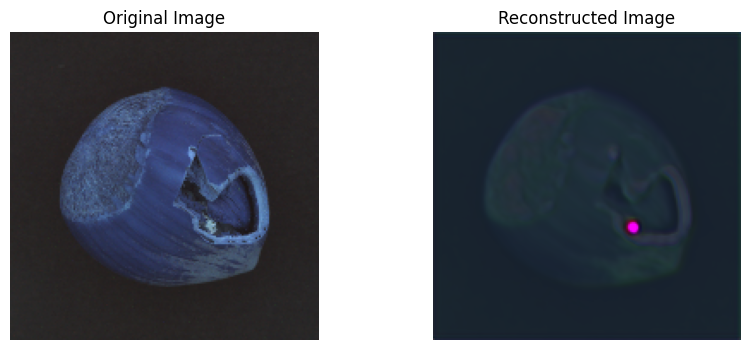

In [ ]:
# Assuming there is an image file in the 'crack' directory
image_file_path = '/content/drive/MyDrive/anomaly/mvtec_anomaly_detection/hazelnut/test/crack/001.png'

# Load and preprocess the test image
test_image = cv2.imread(image_file_path)

# Check if the image is loaded successfully
if test_image is None:
    print(f"Error: Unable to load the image from {image_file_path}")
else:
    # Resize to match the model input shape
    test_image = cv2.resize(test_image, (180, 180))
    # Normalize the pixel values
    test_image = test_image.astype("float32") / 255
    # Add batch dimension
    test_image = np.expand_dims(test_image, axis=0)
    # Use the trained autoencoder to make predictions on the test image
    reconstructed_images = autoencoder.predict(test_image)

    # Calculate the reconstruction error (mean squared error)
    reconstruction_error = np.mean((test_image - reconstructed_images) ** 2)

    # Calculate the mean and standard deviation of the reconstruction errors for the test images.
    mean = np.mean(reconstruction_error)
    std = np.std(reconstruction_error)

    # Set the threshold to be the mean plus two standard deviations.
    threshold = 0.0019
    print('Threshold: ', threshold)

    if reconstruction_error > threshold:
        print('Anomaly')
        print('Reconstruction Error:', reconstruction_error)
        print('Threshold:', threshold)
    else:
        print('No anomaly')
        print('Reconstruction Error:', reconstruction_error)

    # Now you can compare the original and reconstructed images
    plt.figure(figsize=(10, 4))
    # Original image
    plt.subplot(1, 2, 1)
    plt.imshow(test_image.reshape(180, 180, 3))
    plt.title('Original Image')
    plt.axis('off')
    # Reconstructed image
    plt.subplot(1, 2, 2)
    plt.imshow(reconstructed_images.reshape(180, 180, 3))
    plt.title('Reconstructed Image')
    plt.axis('off')
    plt.show()


1/1 [==============================] - 0s 60ms/step
Threshold:  0.00195
Anomaly
Reconstruction Error: 0.008739044
Threshold: 0.00195


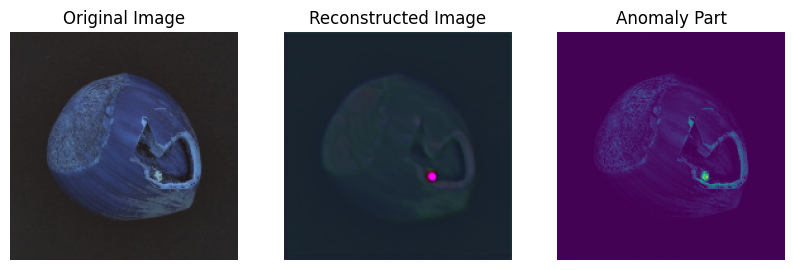

In [ ]:
# Assuming there is an image file in the 'crack' directory
image_file_path = '/content/drive/MyDrive/anomaly/mvtec_anomaly_detection/hazelnut/test/crack/001.png'

# Load and preprocess the test image
test_image = cv2.imread(image_file_path)

# Check if the image is loaded successfully
if test_image is None:
    print(f"Error: Unable to load the image from {image_file_path}")
else:
    # Resize to match the model input shape
    test_image = cv2.resize(test_image, (180, 180))
    # Normalize the pixel values
    test_image = test_image.astype("float32") / 255
    # Add batch dimension
    test_image = np.expand_dims(test_image, axis=0)
    # Use the trained autoencoder to make predictions on the test image
    reconstructed_images = autoencoder.predict(test_image)

    # Calculate the reconstruction error (mean squared error)
    reconstruction_error = np.mean((test_image - reconstructed_images) ** 2)
    reconstruction_error_image = tf.keras.losses.mean_squared_error(test_image, reconstructed_images)

    # Calculate the mean and standard deviation of the reconstruction errors for the test images.
    mean = np.mean(reconstruction_error)
    std = np.std(reconstruction_error)

    # Set the threshold to be the mean plus two standard deviations.
    threshold = 0.00195
    print('Threshold: ', threshold)

    if reconstruction_error > threshold:
        print('Anomaly')
        print('Reconstruction Error:', reconstruction_error)
        print('Threshold:', threshold)
    else:
        print('No anomaly')
        print('Reconstruction Error:', reconstruction_error)

    # Now you can compare the original and reconstructed images
    plt.figure(figsize=(10, 4))
    # Original image
    plt.subplot(1, 3, 1)
    plt.imshow(test_image.reshape(180, 180, 3))
    plt.title('Original Image')
    plt.axis('off')
    # Reconstructed image
    plt.subplot(1, 3, 2)
    plt.imshow(reconstructed_images.reshape(180, 180, 3))
    plt.title('Reconstructed Image')
    plt.axis('off')
    #Abs Diff
    # Reconstructed image
    plt.subplot(1, 3, 3)
    plt.imshow(reconstruction_error_image[0])
    plt.title('Anomaly Part')
    plt.axis('off')
    plt.show()


# Anomaly Detection Broken

1/1 [==============================] - 0s 21ms/step


Threshold: 0.00195
Anomaly
Reconstruction Error: 0.0057760337
Threshold: 0.00195


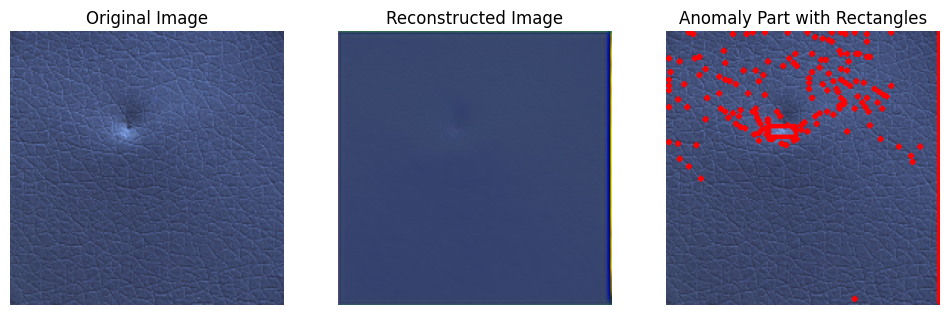

In [ ]:
image_file_path = '/content/drive/MyDrive/anomaly/mvtec_anomaly_detection/leather/test/poke/003.png'

# Load and preprocess the test image
test_image = cv2.imread(image_file_path)

# Check if the image is loaded successfully
if test_image is None:
    print(f"Error: Unable to load the image from {image_file_path}")
else:
    # Resize to match the model input shape
    test_image = cv2.resize(test_image, (180, 180))
    # Normalize the pixel values
    test_image = test_image.astype("float32") / 255
    # Add batch dimension
    test_image = np.expand_dims(test_image, axis=0)
    # Use the trained autoencoder to make predictions on the test image
    reconstructed_images = autoencoder.predict(test_image)

    # Calculate the reconstruction error (mean squared error)
    reconstruction_error_image = tf.keras.losses.mean_squared_error(test_image, reconstructed_images)

    # Calculate the mean and standard deviation of the reconstruction errors for the test images.
    mean = np.mean(reconstruction_error_image)
    std = np.std(reconstruction_error_image)

    # Set the threshold to be the mean plus two standard deviations.
    threshold = 0.00195
    threshold_mask = mean + 1 * std
    print('Threshold:', threshold)

    if reconstruction_error > threshold:
        print('Anomaly')
        print('Reconstruction Error:', reconstruction_error)
        print('Threshold:', threshold)
    else:
        print('No anomaly')
        print('Reconstruction Error:', reconstruction_error)

    # Identify pixels with high reconstruction error
    high_error_pixels = (reconstruction_error_image > threshold_mask).numpy().astype(np.uint8)

    # Find contours of high error areas
    contours, _ = cv2.findContours(high_error_pixels[0], cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Simplify contours with epsilon value to reduce the number of rectangles
    epsilon = 10  # Adjust this value as needed
    simplified_contours = [cv2.approxPolyDP(contour, epsilon, True) for contour in contours]

    # Draw rectangles around high error areas
    result_image = np.copy(test_image[0])
    for contour in simplified_contours:
        x, y, w, h = cv2.boundingRect(contour)
        cv2.rectangle(result_image, (x, y), (x + w, y + h), (255, 0, 0), 2)  # Draw a red rectangle

    # Now you can display the image with highlighted areas
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 3, 1)
    plt.imshow(test_image.reshape(180, 180, 3))
    plt.title('Original Image')
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.imshow(reconstructed_images.reshape(180, 180, 3))
    plt.title('Reconstructed Image')
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.imshow(result_image)
    plt.title('Anomaly Part with Rectangles')
    plt.axis('off')

    plt.show()


# Anomaly Detection

1/1 [==============================] - 0s 21ms/step
Threshold: 0.0021
Anomaly
Reconstruction Error: 0.008739044


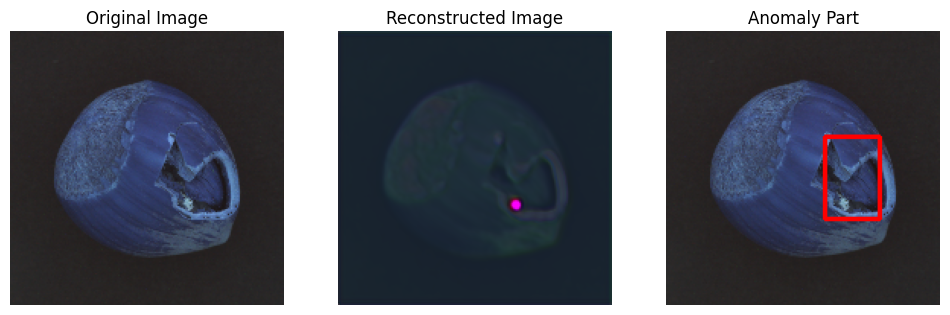

In [ ]:
# Assuming there is an image file in the 'crack' directory
image_file_path = '/content/drive/MyDrive/anomaly/mvtec_anomaly_detection/hazelnut/test/crack/001.png'

# Load and preprocess the test image
test_image = cv2.imread(image_file_path)

# Check if the image is loaded successfully
if test_image is None:
    print(f"Error: Unable to load the image from {image_file_path}")
else:
    # Resize to match the model input shape
    test_image = cv2.resize(test_image, (180, 180))
    # Normalize the pixel values
    test_image = test_image.astype("float32") / 255
    # Add batch dimension
    test_image = np.expand_dims(test_image, axis=0)
    # Use the trained autoencoder to make predictions on the test image
    reconstructed_images = autoencoder.predict(test_image)

    # Calculate the reconstruction error (mean squared error)
    reconstruction_error_image = tf.keras.losses.mean_squared_error(test_image, reconstructed_images)
    reconstruction_error = np.mean(reconstruction_error_image)

    # Calculate the mean and standard deviation of the reconstruction errors for the test images.
    mean = np.mean(reconstruction_error_image)
    std = np.std(reconstruction_error_image)

    # Set the threshold to be the mean plus two standard deviations.
    threshold = 0.0021
    threshold_image = mean + 7 * std
    print('Threshold:', threshold)

    if reconstruction_error > threshold:
        print('Anomaly')
        print('Reconstruction Error:', reconstruction_error)
    else:
        print('No anomaly')
        print('Reconstruction Error:', reconstruction_error)

    # If reconstruction_error > threshold, plot the third plot
    if reconstruction_error > threshold:
        # Identify pixels with high reconstruction error
        high_error_pixels = (reconstruction_error_image > threshold_image).numpy().astype(np.uint8)

        # Find contours of high error areas
        contours, _ = cv2.findContours(high_error_pixels[0], cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

        # Find the three largest contours (rectangles)
        largest_contours = sorted(contours, key=cv2.contourArea, reverse=True)[:5]

        # Calculate the combined bounding box around the three largest contours
        x, y, w, h = cv2.boundingRect(cv2.convexHull(np.vstack(largest_contours)))

        # Draw a single large rectangle around the combined area
        result_image = np.copy(test_image[0])
        cv2.rectangle(result_image, (x, y), (x + w, y + h), (255, 0, 0), 2)  # Draw a red rectangle
    else:
        result_image = np.copy(test_image[0])

    # Now you can display the image with the largest rectangle (or original image if no anomaly)
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 3, 1)
    plt.imshow(test_image.reshape(180, 180, 3))
    plt.title('Original Image')
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.imshow(reconstructed_images.reshape(180, 180, 3))
    plt.title('Reconstructed Image')
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.imshow(result_image)
    if reconstruction_error > threshold:
        plt.title('Anomaly Part')
    else:
        plt.title('No Anomaly')
    plt.axis('off')

    plt.show()

# Heatmap

1/1 [==============================] - 0s 30ms/step
Threshold: 0.002
Anomaly
Reconstruction Error: 0.008739044


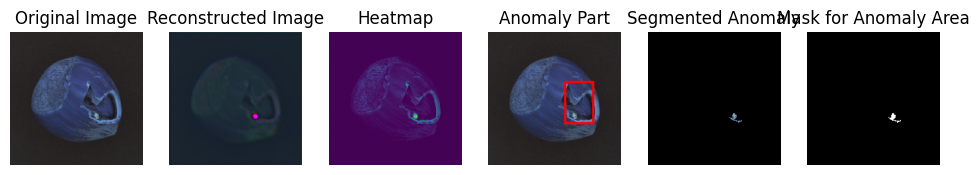

In [ ]:
# Assuming there is an image file in the 'crack' directory
image_file_path = '/content/drive/MyDrive/anomaly/mvtec_anomaly_detection/hazelnut/test/crack/001.png'

# Load and preprocess the test image
test_image = cv2.imread(image_file_path)

# Check if the image is loaded successfully
if test_image is None:
    print(f"Error: Unable to load the image from {image_file_path}")
else:
    # Resize to match the model input shape
    test_image = cv2.resize(test_image, (180, 180))
    # Normalize the pixel values
    test_image = test_image.astype("float32") / 255
    # Add batch dimension
    test_image = np.expand_dims(test_image, axis=0)
    # Use the trained autoencoder to make predictions on the test image
    reconstructed_images = autoencoder.predict(test_image)

    # Calculate the reconstruction error (mean squared error)
    reconstruction_error_image = tf.keras.losses.mean_squared_error(test_image, reconstructed_images)
    error_image = test_image - reconstructed_images
    reconstruction_error = np.mean(reconstruction_error_image)

    # Calculate the mean and standard deviation of the reconstruction errors for the test images.
    mean = np.mean(reconstruction_error_image)
    std = np.std(reconstruction_error_image)

    # Set the threshold to be the mean plus two standard deviations.
    threshold = 0.002
    threshold_image = mean + 6 * std
    print('Threshold:', threshold)

    if reconstruction_error > threshold:
        print('Anomaly')
        print('Reconstruction Error:', reconstruction_error)
    else:
        print('No anomaly')
        print('Reconstruction Error:', reconstruction_error)

    # If reconstruction_error > threshold, plot the third plot
    if reconstruction_error > threshold:
        # Identify pixels with high reconstruction error
        high_error_pixels = (reconstruction_error_image > threshold_image).numpy().astype(np.uint8)

        # Find contours of high error areas
        contours, _ = cv2.findContours(high_error_pixels[0], cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

        # Find the three largest contours (rectangles)
        largest_contours = sorted(contours, key=cv2.contourArea, reverse=True)[:3]

        # Calculate the combined bounding box around the three largest contours
        x, y, w, h = cv2.boundingRect(cv2.convexHull(np.vstack(largest_contours)))

        # Draw a single large rectangle around the combined area
        result_image = np.copy(test_image[0])
        cv2.rectangle(result_image, (x, y), (x + w, y + h), (255, 0, 0), 2)  # Draw a red rectangle

        largest_contour = max(contours, key=cv2.contourArea)

        # Create a mask for the anomaly area based on the largest contour
        mask = np.zeros(test_image[0].shape[:2], dtype=np.uint8)
        cv2.drawContours(mask, [largest_contour], -1, (255), thickness=cv2.FILLED)

        # Apply the mask to the original image for segmentation
        segmented_image = cv2.bitwise_and(test_image[0], test_image[0], mask=mask)
    else:
        result_image = np.copy(test_image[0])


    # Now you can display the image with the largest rectangle (or original image if no anomaly)
    plt.figure(figsize=(12, 10))
    plt.subplot(1,6, 1)
    plt.imshow(test_image.reshape(180, 180, 3))
    plt.title('Original Image')
    plt.axis('off')

    plt.subplot(1, 6, 2)
    plt.imshow(reconstructed_images.reshape(180, 180, 3))
    plt.title('Reconstructed Image')
    plt.axis('off')


    plt.subplot(1, 6, 3)
    plt.imshow(reconstruction_error_image[0])
    plt.title('Heatmap')
    plt.axis('off')

    plt.subplot(1, 6, 4)
    plt.imshow(result_image)
    if reconstruction_error > threshold:
        plt.title('Anomaly Part')
    else:
        plt.title('No Anomaly')
    plt.axis('off')

    plt.subplot(1, 6, 5)
    plt.imshow(segmented_image)
    plt.title('Segmented Anomaly')
    plt.axis('off')

    plt.subplot(1, 6, 6)
    plt.imshow(mask, cmap='gray')
    plt.title('Mask for Anomaly Area')
    plt.axis('off')


    plt.show()

# Clear TF Session

In [ ]:
# Clear the TensorFlow session
K.clear_session()

NameError: ignored

# Save Model & Load Model

In [ ]:
# Save the entire model to a file
autoencoder.save('/content/drive/MyDrive/resnet_autoencoder_burak_capsule.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
path_saved_model = '/content/drive/MyDrive/resnet_autoencoder_burak.h5'

In [ ]:
autoencoder = load_model(path_saved_model)